# Logistic Regression

In [1]:
# UCI repo -----------------------
from ucimlrepo import fetch_ucirepo

# Data Science -------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning ---------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import confusion_matrix, classification_report

# Utils --------------------------
import sys  
sys.path.insert(1, '../utils')
import heatmatrix as hm
import preprocess as pp

## 1. Data
- Fetch from UCI
- Preprocess acordinto do [Dtype Optimization](/Users/felipecampelo/dev/projects/german_credit/notebooks/dtype_optimization.ipynb)

In [2]:
# Fetch and preprocess data

# Fetch
df = fetch_ucirepo(id=144).data.original

# Dtype preprocessing
df = pp.preprocess_dtypes(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Attribute1   1000 non-null   category
 1   Attribute2   1000 non-null   int64   
 2   Attribute3   1000 non-null   category
 3   Attribute4   1000 non-null   category
 4   Attribute5   1000 non-null   int64   
 5   Attribute6   1000 non-null   category
 6   Attribute7   1000 non-null   category
 7   Attribute8   1000 non-null   int64   
 8   Attribute9   1000 non-null   category
 9   Attribute10  1000 non-null   category
 10  Attribute11  1000 non-null   int64   
 11  Attribute12  1000 non-null   category
 12  Attribute13  1000 non-null   int64   
 13  Attribute14  1000 non-null   category
 14  Attribute15  1000 non-null   category
 15  Attribute16  1000 non-null   int64   
 16  Attribute17  1000 non-null   category
 17  Attribute18  1000 non-null   int64   
 18  Attribute19  1000 non-null   

In [3]:
# X and y
X = df.select_dtypes(include=np.number)
y = df['Target']

display('X', X.head())
display('y', y.head().to_frame())

'X'

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


'y'

,Target
0,True
1,False
2,True
3,True
4,False


## 2. Split

In [4]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Scale

In [5]:
# MinMaxScaler
scaler = MinMaxScaler()

### Original mean and std
std_original = X.describe().loc[['mean', 'std']]

# Scale the data
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Bring back to DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test,  columns=X.columns)

### Scaled mean and std
std_scaled = X_train.describe().loc[['mean', 'std']]

display("Original", std_original)
display("Scaled", std_scaled)

'Original'

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086


'Scaled'

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
mean,0.308087,0.173700,0.660476,0.611429,0.294515,0.140000,0.137143
std,0.212501,0.163525,0.372893,0.367746,0.200947,0.193898,0.344244


## 4. Model

In [6]:
# Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

## 5. Metrics

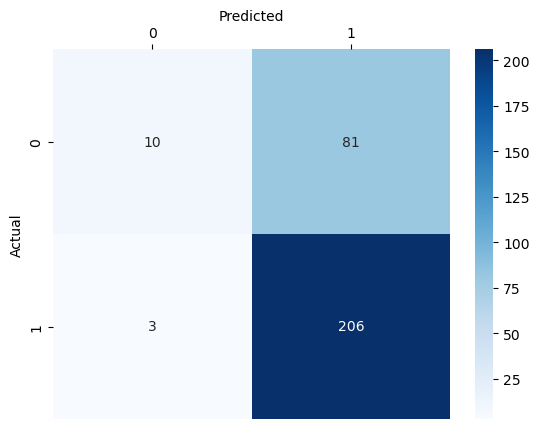

In [7]:
# Model in a Confusion Matrix
hm.cm_heatmap(confusion_matrix(y_test, y_pred), 'Blues')

,precision,recall,f1-score,support
False,0.769231,0.109890,0.192308,91.00
True,0.717770,0.985646,0.830645,209.00
accuracy,0.720000,0.720000,0.720000,0.72
macro avg,0.743500,0.547768,0.511476,300.00
weighted avg,0.733380,0.720000,0.637016,300.00


<Axes: >

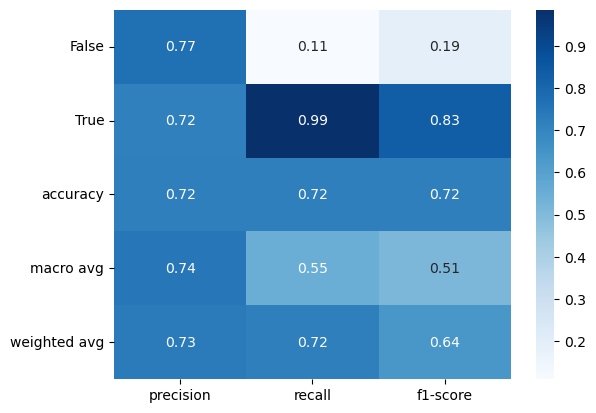

In [8]:
# Model in a Classification Report
cr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
display(cr)

# Classification Report Heatmap
display(sns.heatmap(cr.drop(columns='support'), annot=True, fmt='.2f', cmap='Blues'))

> The logistic model is rather low performant on the false targets.

> That might be due to imbalances in the dataset 
which is comfirmed by the 70/30 distributions seen in [German Credit @4.4 Distributions](/Users/felipecampelo/dev/projects/german_credit/notebooks/the_data.ipynb)